# Module 3 Homework

ATTENTION: At the end of the submission form, you will be required to include a link to your GitHub repository or other public code-hosting site. This repository should contain your code for solving the homework. If your solution includes code that is not in file format (such as SQL queries or shell commands), please include these directly in the README file of your repository.

Important Note:

For this homework we will be using the Yellow Taxi Trip Records for January 2024 - June 2024 NOT the entire year of data Parquet Files from the New York City Taxi Data found here:
https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
If you are using orchestration such as Kestra, Mage, Airflow or Prefect etc. do not load the data into Big Query using the orchestrator.
Stop with loading the files into a bucket.


Load Script: You can manually download the parquet files and upload them to your GCS Bucket or you can use the linked script here:
You will simply need to generate a Service Account with GCS Admin Priveleges or be authenticated with the Google SDK and update the bucket name in the script to the name of your bucket
Nothing is fool proof so make sure that all 6 files show in your GCS Bucket before begining.


NOTE: You will need to use the PARQUET option files when creating an External Table

BIG QUERY SETUP:
Create an external table using the Yellow Taxi Trip Records.
Create a (regular/materialized) table in BQ using the Yellow Taxi Trip Records (do not partition or cluster this table).

python load_yellow_taxi_data.py

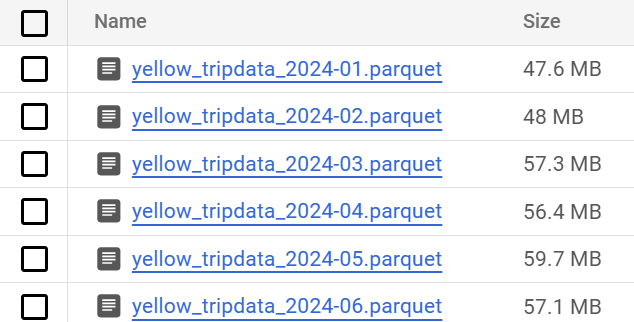

CREATE OR REPLACE EXTERNAL TABLE `zoomcamp.external_yellow_tripdata`
OPTIONS (
  format = 'PARQUET',
  uris = ['gs://dezoomcamp_hw3_2025_id/yellow_tripdata_2024-*.parquet']
);

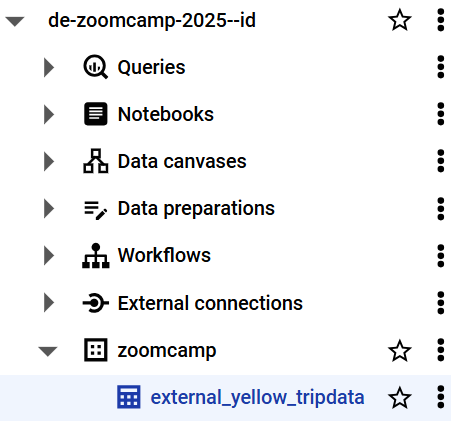

CREATE OR REPLACE TABLE zoomcamp.yellow_tripdata_materialized AS
SELECT * FROM zoomcamp.external_yellow_tripdata;


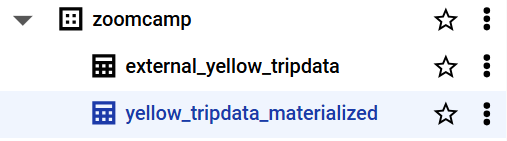

## Question 1:
Question 1: What is count of records for the 2024 Yellow Taxi Data?

- 65,623
- 840,402
- `20,332,093`
- 85,431,289

### Solution

SELECT COUNT(*) FROM zoomcamp.yellow_tripdata_materialized;

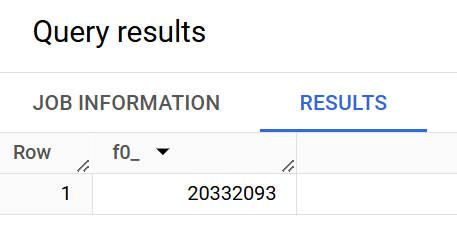

### Answer 1:
20,332,093

## Question 2:
Write a query to count the distinct number of PULocationIDs for the entire dataset on both the tables.
What is the estimated amount of data that will be read when this query is executed on the External Table and the Table?

- 18.82 MB for the External Table and 47.60 MB for the Materialized Table
- 0 MB for the External Table and 155.12 MB for the Materialized Table
- 2.14 GB for the External Table and 0MB for the Materialized Table
- `0 MB for the External Table and 0MB for the Materialized Table`


### Solution
SELECT COUNT(DISTINCT PULocationID) FROM zoomcamp.external_yellow_tripdata;
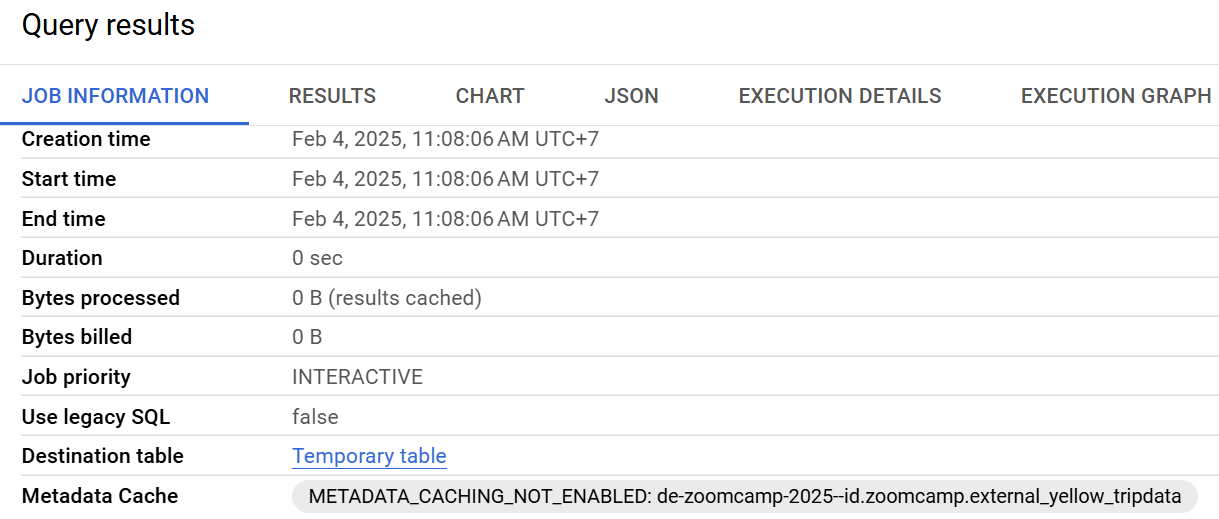
-- Bytes processed: 0 B (results cached)


SELECT COUNT(DISTINCT PULocationID) FROM `zoomcamp.yellow_tripdata_materialized`;
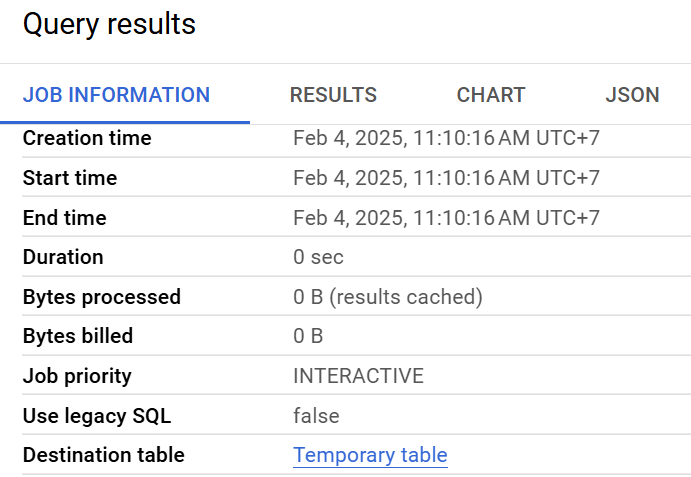
-- Bytes processed: 0 B

### Answer 2:
0 MB for the External Table and 0MB for the Materialized Table

## Question 3:
Write a query to retrieve the PULocationID form the table (not the external table) in BigQuery. Now write a query to retrieve the PULocationID and DOLocationID on the same table. Why are the estimated number of Bytes different?

- `BigQuery is a columnar database, and it only scans the specific columns requested in the query. Querying two columns (PULocationID, DOLocationID) requires reading more data than querying one column (PULocationID), leading to a higher estimated number of bytes processed.`
- BigQuery duplicates data across multiple storage partitions, so selecting two columns instead of one requires scanning the table twice, doubling the estimated bytes processed.
- BigQuery automatically caches the first queried column, so adding a second column increases processing time but does not affect the estimated bytes scanned.
- When selecting multiple columns, BigQuery performs an implicit join operation between them, increasing the estimated bytes processed

### Solution
SELECT PULocationID FROM zoomcamp.yellow_tripdata_materialized;
-- Bytes processed: 155.12 MB

SELECT PULocationID, DOLocationID FROM zoomcamp.yellow_tripdata_materialized;
-- Bytes processed: 310.24 MB

### Answer 3:
BigQuery is a columnar database, and it only scans the specific columns requested in the query. Querying two columns (PULocationID, DOLocationID) requires reading more data than querying one column (PULocationID), leading to a higher estimated number of bytes processed.

## Question 4:
How many records have a fare_amount of 0?

- 128,210
- 546,578
- 20,188,016
- `8,333`

### Solution
SELECT COUNT(*) FROM zoomcamp.yellow_tripdata_materialized 
WHERE fare_amount = 0;
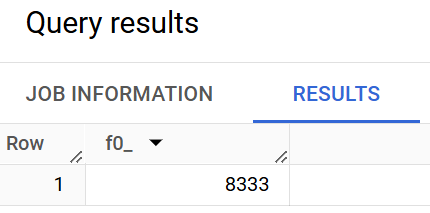

### Answer 4:
8,333

## Question 5:
What is the best strategy to make an optimized table in Big Query if your query will always filter based on tpep_dropoff_timedate and order the results by VendorID (Create a new table with this strategy)

- `Partition by tpep_dropoff_timedate and Cluster on VendorID`
- Cluster on by tpep_dropoff_timedate and Cluster on VendorID
- Cluster on tpep_dropoff_timedate Partition by VendorID
- Partition by tpep_dropoff_timedate and Partition by VendorID

### Solution
Best partcice for query performance:

- Filter on partitioned columns
- the order of the columns in which the clustering is specified is important in order to determine the column priority

CREATE OR REPLACE TABLE zoomcamp.yellow_tripdata_partitoned_clustered
PARTITION BY DATE(tpep_pickup_datetime)
CLUSTER BY VendorID AS
SELECT * FROM zoomcamp.external_yellow_tripdata;

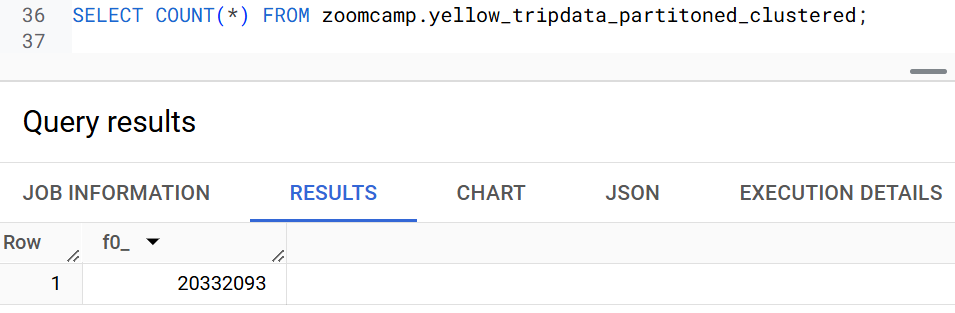

### Answer 4:
Partition by tpep_dropoff_timedate and Cluster on VendorID

## Question 6:
Write a query to retrieve the distinct VendorIDs between tpep_dropoff_timedate 03/01/2024 and 03/15/2024 (inclusive)

Use the materialized table you created earlier in your from clause and note the estimated bytes. Now change the table in the from clause to the partitioned table you created for question 4 and note the estimated bytes processed. What are these values?

Choose the answer which most closely matches.

- 12.47 MB for non-partitioned table and 326.42 MB for the partitioned table
- `310.24 MB for non-partitioned table and 26.84 MB for the partitioned table`
- 5.87 MB for non-partitioned table and 0 MB for the partitioned table
- 310.31 MB for non-partitioned table and 285.64 MB for the partitioned table

### Solution

SELECT DISTINCT VendorID FROM zoomcamp.yellow_tripdata_materialized
-- WHERE tpep_dropoff_datetime BETWEEN '2024-03-01' AND '2024-03-15';
WHERE tpep_dropoff_datetime > '2024-03-01' AND tpep_dropoff_datetime <= '2024-03-15';

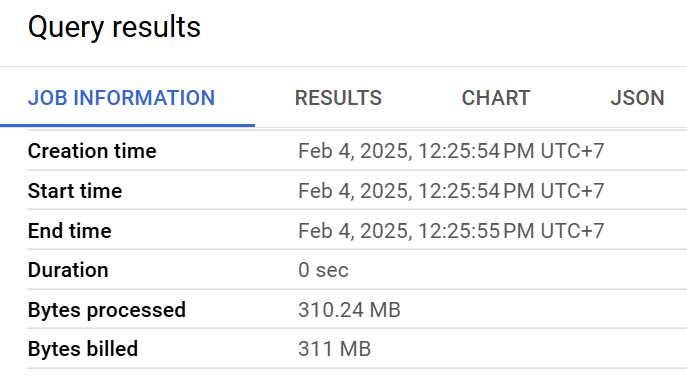

SELECT DISTINCT VendorID FROM zoomcamp.yellow_tripdata_partitoned_clustered
-- WHERE tpep_dropoff_datetime BETWEEN '2024-03-01' AND '2024-03-15';
WHERE tpep_dropoff_datetime > '2024-03-01' AND tpep_dropoff_datetime <= '2024-03-15';

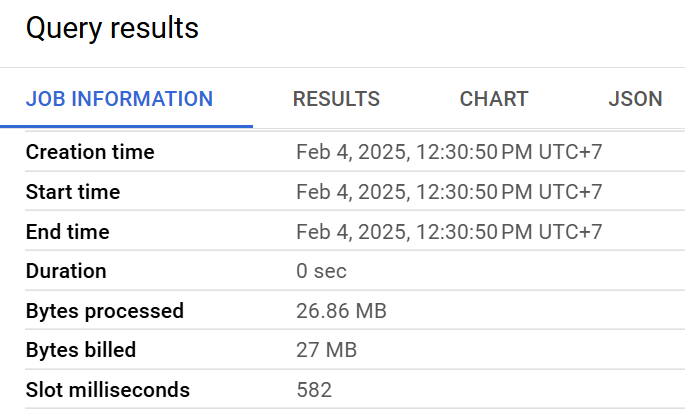

### Answer 6:
310.24 MB for non-partitioned table and 26.84 MB for the partitioned table


## Question 7:
Where is the data stored in the External Table you created?

- Big Query
- Container Registry
- `GCP Bucket`
- Big Table

### Sulotion

When we create an External Table in BigQuery, the data itself is not stored within BigQuery. Instead, the data resides in an external storage location, such as a Google Cloud Storage (GCS) Bucket. BigQuery only stores metadata about the external table (e.g., schema, file locations) and accesses the data directly from the external source (e.g., GCS) when queries are executed.

### Answer 7:
GCP Bucket



## Question 8:
It is best practice in Big Query to always cluster your data:

- True
- `False`

### Solution

Clustering in BigQuery is a powerful feature that can improve query performance and reduce costs by organizing data based on one or more columns. However, it is not always necessary or beneficial to cluster your data. Whether or not to cluster depends on factors such as:

- Query Patterns: Clustering is most useful when your queries frequently filter or aggregate data based on the clustered columns.
- Data Size: For small datasets, clustering may not provide significant performance improvements.
- Cost vs. Benefit: Clustering can increase storage costs slightly, so it should only be used when the performance benefits outweigh the costs.
- Data Updates: Clustering is more effective for static or slowly changing data. If your data changes frequently, clustering may not be as effective.

When to Cluster:
- When you have large datasets and specific query patterns that filter or group by certain columns.
- When you want to optimize query performance and reduce the amount of data scanned.

When Not to Cluster:
- For small datasets where the performance gains are negligible.
- If your queries do not frequently filter or group by specific columns.
- If your data changes frequently, as clustering may not be as effective.

Conclusion:
Clustering is a best practice in specific scenarios, but it is not a blanket rule for all datasets in BigQuery. Always evaluate your use case before deciding to cluster your data.

### Answer 8:
False
